In [ ]:
import os
import sys
from pathlib import Path

# FOR LOCAL USE THIS LINES
current = Path.cwd()
src_path = current / "src" if (current / "src").exists() else current.parent

# FOR COLAB USE THIS LINE INSTEAD
# BRANCH_NAME = "partitioning"  # Change this to switch branches
# !git clone -b {BRANCH_NAME} https://github.com/MatteoCamillo-code/GeoLoc-CVCS.git
# !cd /content/GeoLoc-CVCS && git pull origin {BRANCH_NAME} && cd ..
# src_path = Path("/content/GeoLoc-CVCS/src").resolve()

sys.path.insert(0, str(src_path))

from utils.paths import find_project_root

# Set working directory and sys.path properly
project_root = find_project_root(src_path)
os.chdir(project_root)
sys.path.insert(0, str(project_root / "src"))

Cloning into 'GeoLoc-CVCS'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 439 (delta 80), reused 110 (delta 50), pack-reused 284 (from 2)
Receiving objects: 100% (439/439), 73.73 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (199/199), done.
Updating files: 100% (66/66), done.
From https://github.com/MatteoCamillo-code/GeoLoc-CVCS
 * branch            partitioning -> FETCH_HEAD
Already up to date.


In [2]:
!cd /content/GeoLoc-CVCS/ && git branch -r

  origin/HEAD -> origin/main
  origin/ISN
  origin/architecture
  origin/inception_v4
  origin/inference_multi_classifier
  origin/main
  origin/partitioning
  origin/refactoring
  origin/s2_refactoring
  origin/windows


In [3]:
!pip install s2sphere

In [4]:
import pandas as pd
import geopandas as gpd

from src.map_partitioning.s2.config import S2Config
from src.map_partitioning.s2.plotting import plot_density_map, plot_s2_cell_maps_trio, plot_s2_cell_maps
from src.map_partitioning.s2.utils import get_s2_cell_id, perform_train_val_split, create_cell_center_dataset
from src.map_partitioning.s2.partition import s2_partitioning

In [5]:
cfg = S2Config(project_root)

# --- 1. DATA LOADING & INITIAL S2 PROCESSING ---
print("Loading data...")
df = pd.read_csv(cfg.INPUT_TRAIN)

# Generate S2 cells at the most granular level (Level 30)
print("Generating S2 Cell IDs for all points...")
df['s2_cell'] = [
    get_s2_cell_id(lat, lng)
    for lat, lng in zip(df['latitude'], df['longitude'])
]

Loading data...
Generating S2 Cell IDs for all points...


In [6]:
# --- 2. TRAIN/VAL SPLIT ---
print("Performing Train/Validation split...")
df_train, df_val = perform_train_val_split(df)

Performing Train/Validation split...


Loading USA map for density plot...


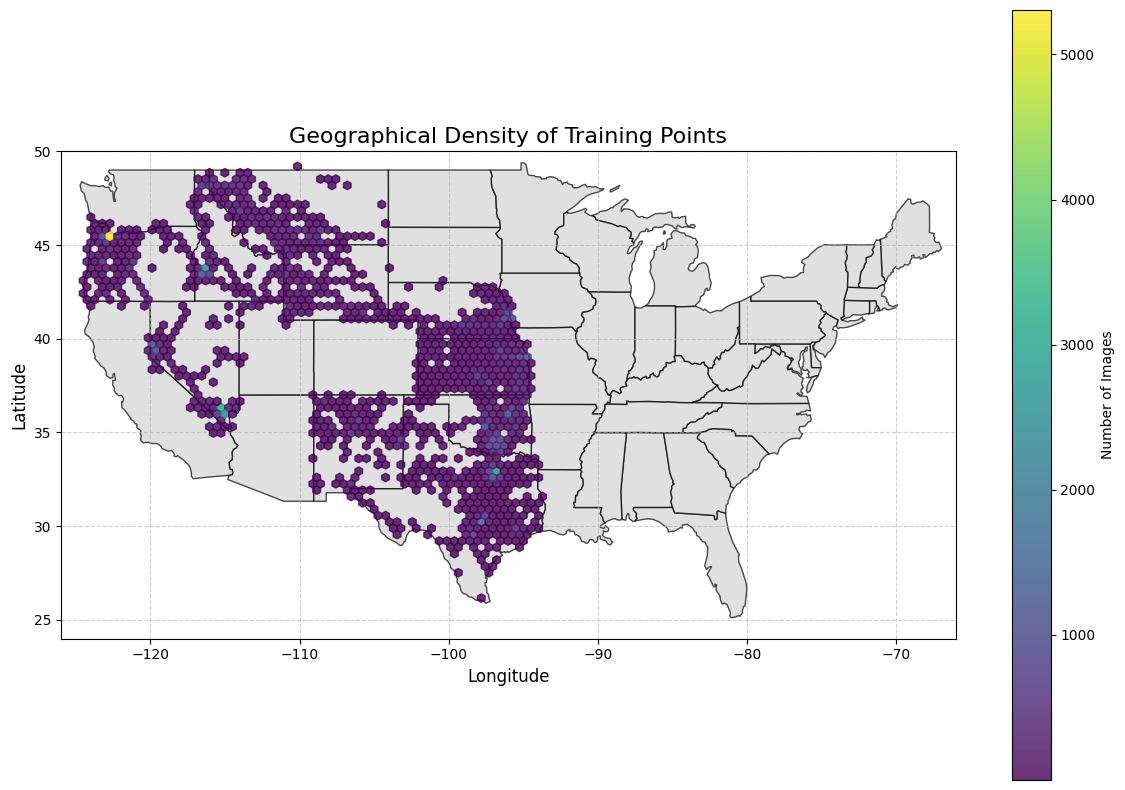


Density Map Completed


In [7]:
# --- 3. VISUALIZATION: DENSITY MAP ---
plot_density_map(
    df_train,
    title="Geographical Density of Training Points",
    x_label="Longitude",
    y_label="Latitude"
)

In [8]:
df_train_urban = df_train[df_train['predicted_label'] == 'Urban']
df_train_natural = df_train[df_train['predicted_label'] == 'Natural']
df_val_urban = df_val[df_val['predicted_label'] == 'Urban']
df_val_natural = df_val[df_val['predicted_label'] == 'Natural']

In [9]:
# --- 4. RUN S2 PARTITIONINGS ---
trained_partitions_total, trained_lookups_total, df_train_total, df_val_total = s2_partitioning(
    df_train,
    df_val,
    cfg.PARTITION_CONFIGS
)

trained_partitions_urban, trained_lookups_urban, df_train_urban, df_val_urban = s2_partitioning(
    df_train_urban,
    df_val_urban,
    cfg.PARTITION_CONFIGS
)

trained_partitions_natural, trained_lookups_natural, df_train_natural, df_val_natural = s2_partitioning(
    df_train_natural,
    df_val_natural,
    cfg.PARTITION_CONFIGS
)



Starting S2 Cell Partitioning and Labeling

Partitioning config_1 (tau_max=50)...
Number of cells (classes) created: 4742


 Mapping config_1: 100%|██████████| 17852/17852 [00:00<00:00, 21916.77it/s]



Partitioning config_2 (tau_max=100)...
Number of cells (classes) created: 2509


 Mapping config_2: 100%|██████████| 17852/17852 [00:00<00:00, 21994.61it/s]



Partitioning config_3 (tau_max=200)...
Number of cells (classes) created: 1337


 Mapping config_3: 100%|██████████| 17852/17852 [00:00<00:00, 19723.48it/s]



 
S2 Cell Partitioning and Labeling completed.

Starting S2 Cell Partitioning and Labeling

Partitioning config_1 (tau_max=50)...
Number of cells (classes) created: 1560


 Mapping config_1: 100%|██████████| 29329/29329 [00:01<00:00, 22420.58it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, col_name] = [fast_assign_label(p, lookup) for p in tqdm(df_train['s2_cell'], desc=f" Mapping {cfg['name']}")]
 Mapping config_1: 100%|██████████| 5241/5241 [00:00<00:00, 23206.91it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, col_na


Partitioning config_2 (tau_max=100)...
Number of cells (classes) created: 884


 Mapping config_2: 100%|██████████| 29329/29329 [00:01<00:00, 22780.63it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, col_name] = [fast_assign_label(p, lookup) for p in tqdm(df_train['s2_cell'], desc=f" Mapping {cfg['name']}")]
 Mapping config_2: 100%|██████████| 5241/5241 [00:00<00:00, 20342.27it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, col_na


Partitioning config_3 (tau_max=200)...
Number of cells (classes) created: 442


 Mapping config_3: 100%|██████████| 29329/29329 [00:01<00:00, 21487.41it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, col_name] = [fast_assign_label(p, lookup) for p in tqdm(df_train['s2_cell'], desc=f" Mapping {cfg['name']}")]
 Mapping config_3: 100%|██████████| 5241/5241 [00:00<00:00, 20830.29it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, col_na


 
S2 Cell Partitioning and Labeling completed.

Starting S2 Cell Partitioning and Labeling

Partitioning config_1 (tau_max=50)...
Number of cells (classes) created: 3253


 Mapping config_1: 100%|██████████| 71534/71534 [00:03<00:00, 21893.88it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, col_name] = [fast_assign_label(p, lookup) for p in tqdm(df_train['s2_cell'], desc=f" Mapping {cfg['name']}")]
 Mapping config_1: 100%|██████████| 12562/12562 [00:00<00:00, 21575.22it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, col_


Partitioning config_2 (tau_max=100)...
Number of cells (classes) created: 1761


 Mapping config_2: 100%|██████████| 71534/71534 [00:03<00:00, 21220.40it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, col_name] = [fast_assign_label(p, lookup) for p in tqdm(df_train['s2_cell'], desc=f" Mapping {cfg['name']}")]
 Mapping config_2: 100%|██████████| 12562/12562 [00:00<00:00, 21155.85it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, col_


Partitioning config_3 (tau_max=200)...
Number of cells (classes) created: 917


 Mapping config_3: 100%|██████████| 71534/71534 [00:03<00:00, 20944.04it/s]
/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, col_name] = [fast_assign_label(p, lookup) for p in tqdm(df_train['s2_cell'], desc=f" Mapping {cfg['name']}")]
 Mapping config_3: 100%|██████████| 12562/12562 [00:00<00:00, 19875.06it/s]


 
S2 Cell Partitioning and Labeling completed.



/content/GeoLoc-CVCS/src/map_partitioning/s2/partition.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, col_name] = [fast_assign_label(p, lookup) for p in tqdm(df_val['s2_cell'], desc=f" Mapping {cfg['name']}")]


In [10]:
df_train_urban

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_city,unique_country,creator_username,creator_id,predicted_label,s2_cell,is_train,label_config_1,label_config_2,label_config_3
168,480477566705838,32.341205,-108.714258,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,yymssgs2hsgh94xilt1gvr,1460296895236,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Urban,CellId: 86d901886da02591,1,86d9,86d,86d
233,935243457307281,32.343266,-108.711893,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,yymssgs2hsgh94xilt1gvr,1460296864040,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Urban,CellId: 86d902278347a5d3,1,86d9,86d,86d
236,1642911435899155,32.350140,-108.709952,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,yymssgs2hsgh94xilt1gvr,1460296751233,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Urban,CellId: 86d902204dd341cd,1,86d9,86d,86d
286,539924620728632,32.344727,-108.710704,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,yymssgs2hsgh94xilt1gvr,1460297067841,18.0,64.0,"(18, 64)",...,Lordsburg_Hidalgo County_New Mexico_US,US,drkludge,1.106021e+14,Urban,CellId: 86d902271154892b,1,86d9,86d,86d
348,539140553753931,31.832838,-106.535743,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,uvzm3t41h8mdy0vf8lbw5g,1512492720437,19.0,64.0,"(19, 64)",...,Sunland Park_Dona Ana County_New Mexico_US,US,lvl5,1.044090e+14,Urban,CellId: 86ddf8760f2bba31,1,86dd,86d,86d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118989,608007327608194,36.020671,-115.145765,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,GFAEblS5vgu2qJifNjp9Le,1658518345033,17.0,67.0,"(17, 67)",...,Paradise_Clark County_Nevada_US,US,bekind,1.040158e+14,Urban,CellId: 80c8cef914f7440b,1,80c8cec,80c8cec,80c8cc
118995,1372153146493345,36.128008,-115.132008,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,5xkfdfr0maxg9sn7eklmde,1576095219193,17.0,67.0,"(17, 67)",...,Winchester_Clark County_Nevada_US,US,chksnthemail,1.013162e+14,Urban,CellId: 80c8c4f230ddd017,1,80c8c4f,80c8c4c,80c8c4c
118996,518426382954598,39.623159,-119.904151,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,r7QoXNp1Hq6VWcRy8UIsig,1647428523000,15.0,70.0,"(15, 70)",...,Lemmon Valley_Washoe County_Nevada_US,US,marker_geo,1.029002e+14,Urban,CellId: 80994edd5082601f,1,80994f,80994c,80994c
119000,723136002453483,39.508593,-119.896636,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,WueVrgaYj4QXb3qsHSGvfE,1648711856000,15.0,69.0,"(15, 69)",...,Mogul_Washoe County_Nevada_US,US,marker_geo,1.029002e+14,Urban,CellId: 8099440edadcaf9b,1,809945,809945,809945


Loading USA map for visualization...


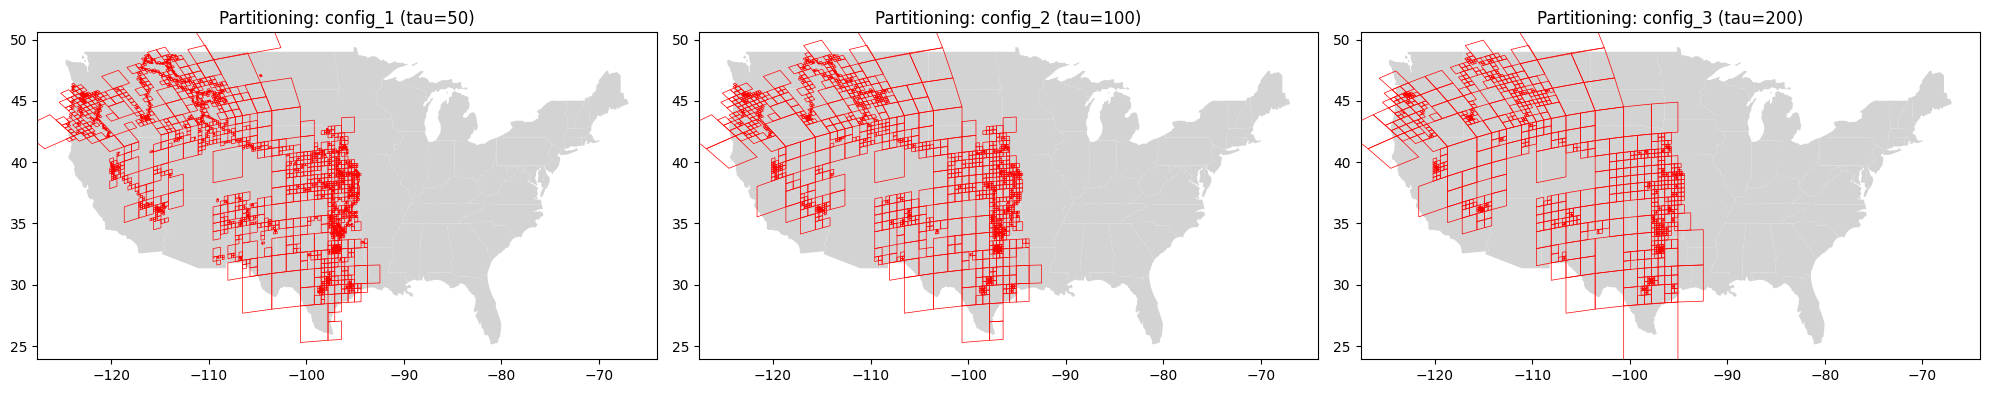

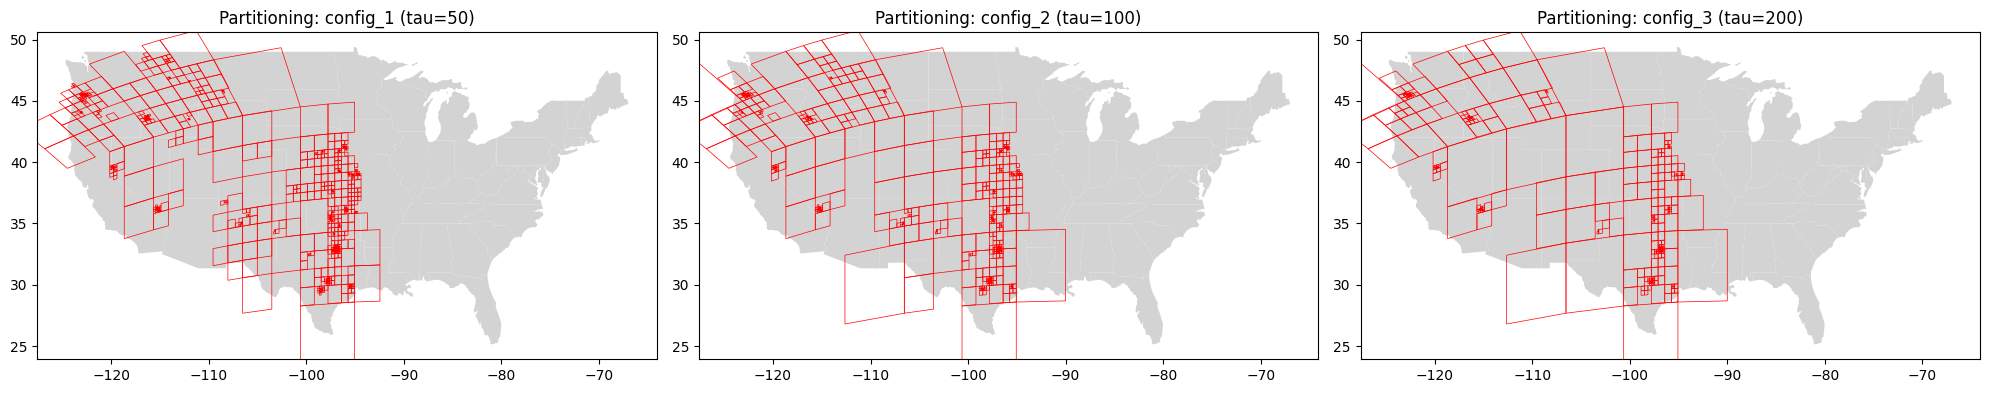

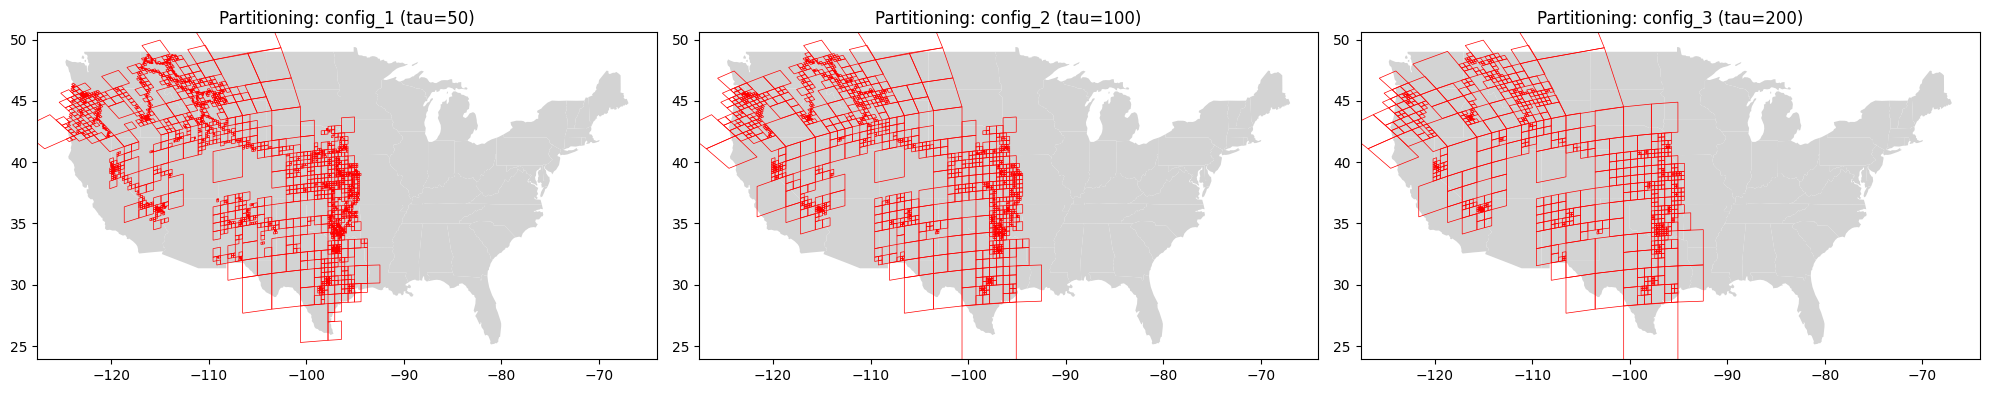

In [11]:
# --- 5. VISUALIZATION: S2 CELL GRID ---
print("Loading USA map for visualization...")
usa_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(usa_url)
usa = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Plot the resulting grids for each config side-by-side
plot_s2_cell_maps_trio(
    cfg.PARTITION_CONFIGS,
    trained_partitions_total,
    df_train_total,
    usa,
    #save_images=True,
    #output_dir=tbd
)

# Plot the resulting grids for each config side-by-side
plot_s2_cell_maps_trio(
    cfg.PARTITION_CONFIGS,
    trained_partitions_urban,
    df_train_urban,
    usa,
    #save_images=True,
    #output_dir=tbd
)

# Plot the resulting grids for each config side-by-side
plot_s2_cell_maps_trio(
    cfg.PARTITION_CONFIGS,
    trained_partitions_natural,
    df_train_natural,
    usa,
    #save_images=True,
    #output_dir=tbd
)

Generating S2 cell maps...


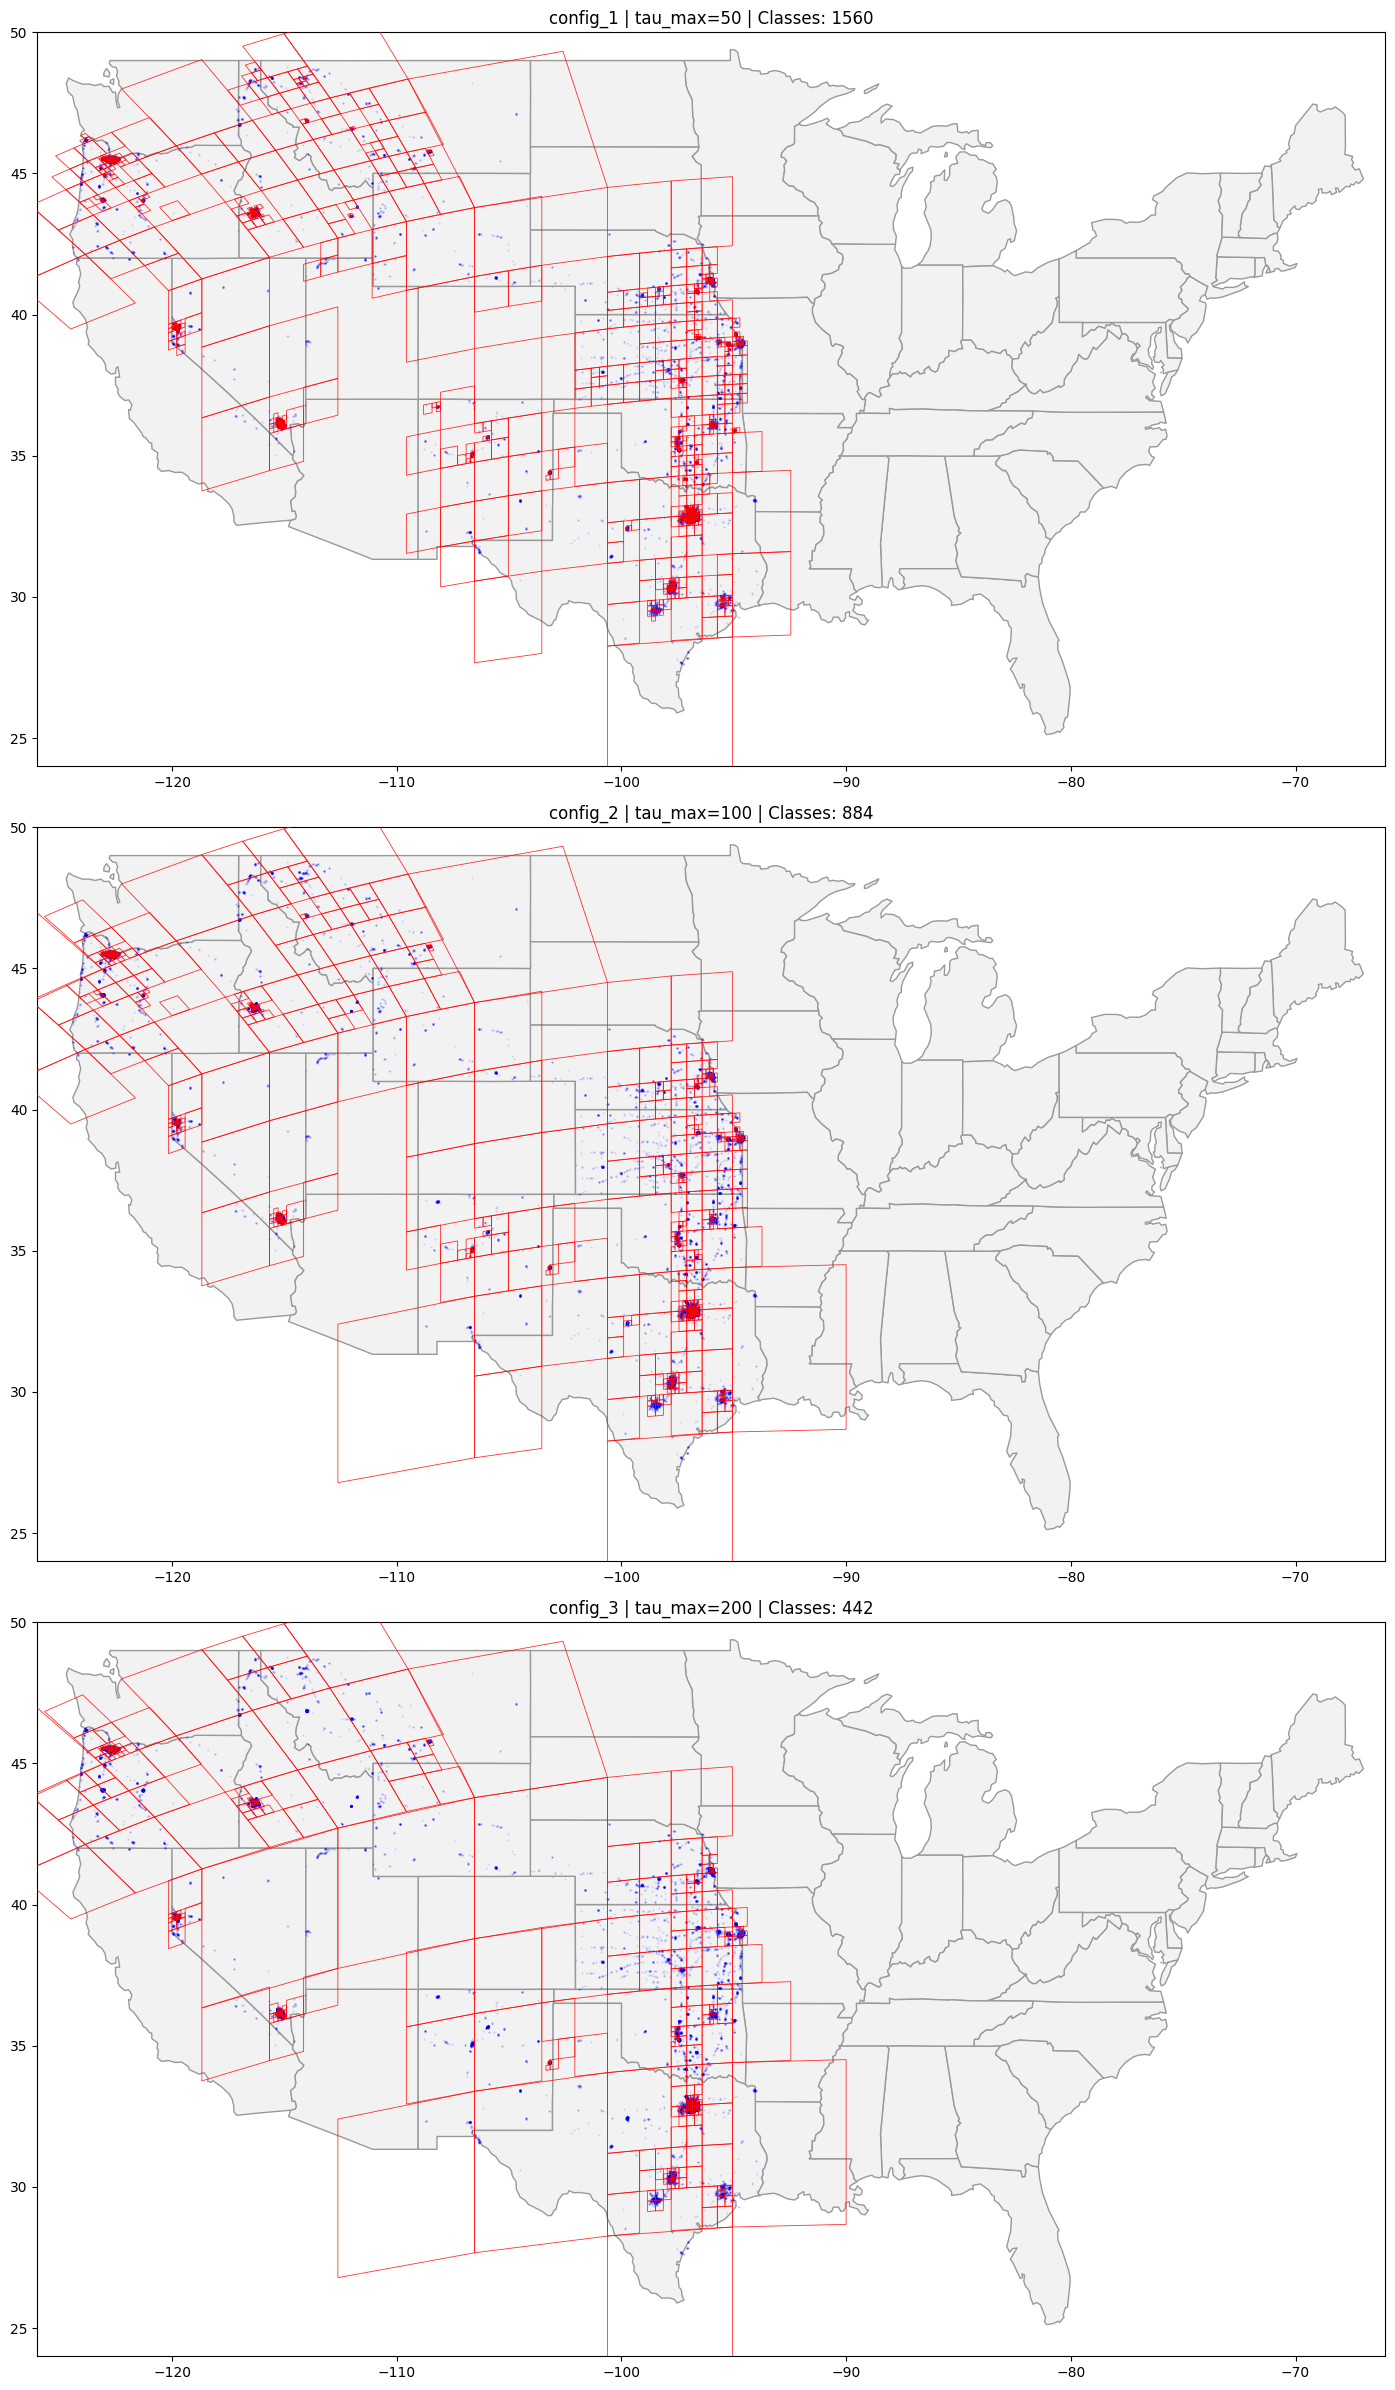


S2 Cell Map Generation Completed


In [12]:
plot_s2_cell_maps(
    configs=cfg.PARTITION_CONFIGS,
    trained_partitions=trained_partitions_urban,
    df_train=df_train_urban,
    usa=usa,
    save_images=False
)

In [13]:
# --- 6. CREATE AND CELL CENTER DATASET ---
combined_cell_df_total = create_cell_center_dataset(cfg.PARTITION_CONFIGS, trained_partitions_total)
combined_cell_df_urban = create_cell_center_dataset(cfg.PARTITION_CONFIGS, trained_partitions_urban)
combined_cell_df_natural = create_cell_center_dataset(cfg.PARTITION_CONFIGS, trained_partitions_natural)

# Display preview
print("Combined Cell Centers DataFrame (first 5 rows):")
display(combined_cell_df_total.head())

Reconstructing cell centers for each configuration...


   Processing config_3 cells: 100%|██████████| 1337/1337 [00:00<00:00, 77637.89it/s]


Combined Cell Centers DataFrame created.
Total rows in the combined DataFrame: 8588
Reconstructing cell centers for each configuration...


   Processing config_3 cells: 100%|██████████| 442/442 [00:00<00:00, 51285.89it/s]


Combined Cell Centers DataFrame created.
Total rows in the combined DataFrame: 2886
Reconstructing cell centers for each configuration...


   Processing config_3 cells: 100%|██████████| 917/917 [00:00<00:00, 79369.71it/s]


Combined Cell Centers DataFrame created.
Total rows in the combined DataFrame: 5931
Combined Cell Centers DataFrame (first 5 rows):


,cell_id_token,center_latitude,center_longitude,count,config_name
0,86d84,32.648380,-109.188005,5,config_1
1,86d904,32.286026,-108.712579,42,config_1
2,86d914,32.139738,-108.522571,1,config_1
3,86d91c,32.314937,-108.522571,8,config_1
4,86d99,31.804084,-108.997769,6,config_1


In [14]:
# --- 7. SAVE RESULTS (Optional) ---
print(f"Saving partitioned data to: {cfg.OUTPUT_TRAIN}")
df_combined_total = pd.concat([df_train_total, df_val_total], ignore_index=True)
df_combined_total.to_csv(cfg.OUTPUT_TRAIN, index=False)

print(f"Saving center datasets to: {cfg.OUTPUT_CELL_CENTER}")
combined_cell_df_total.to_csv(cfg.OUTPUT_CELL_CENTER, index=False)

####

print(f"Saving partitioned data to: {cfg.OUTPUT_TRAIN_URBAN}")
df_combined_urban = pd.concat([df_train_urban, df_val_urban], ignore_index=True)
df_combined_urban.to_csv(cfg.OUTPUT_TRAIN_URBAN, index=False)

print(f"Saving center datasets to: {cfg.OUTPUT_CELL_CENTER_URBAN}")
combined_cell_df_urban.to_csv(cfg.OUTPUT_CELL_CENTER_URBAN, index=False)

####

print(f"Saving partitioned data to: {cfg.OUTPUT_TRAIN_NATURAL}")
df_combined_natural = pd.concat([df_train_natural, df_val_natural], ignore_index=True)
df_combined_natural.to_csv(cfg.OUTPUT_TRAIN_NATURAL, index=False)

print(f"Saving center datasets to: {cfg.OUTPUT_CELL_CENTER_NATURAL}")
combined_cell_df_natural.to_csv(cfg.OUTPUT_CELL_CENTER_NATURAL, index=False)

Saving partitioned data to: /content/GeoLoc-CVCS/data/metadata/s2-geo-cells/train_val_split_geocells_total.csv
Saving center datasets to: /content/GeoLoc-CVCS/data/metadata/s2-geo-cells/cell_center_dataset_total.csv
Saving partitioned data to: /content/GeoLoc-CVCS/data/metadata/s2-geo-cells/train_val_split_geocells_urban.csv
Saving center datasets to: /content/GeoLoc-CVCS/data/metadata/s2-geo-cells/cell_center_dataset_urban.csv
Saving partitioned data to: /content/GeoLoc-CVCS/data/metadata/s2-geo-cells/train_val_split_geocells_natural.csv
Saving center datasets to: /content/GeoLoc-CVCS/data/metadata/s2-geo-cells/cell_center_dataset_natural.csv


In [15]:
import pandas as pd
from s2sphere import CellId

def find_representative_in_level(child_token, level_group_set):
    """
    Finds the cell itself or its closest ancestor within a specific group.
    Used to map fine-grained cells to coarse-grained geoclasses[cite: 104, 111].
    """
    if not child_token or pd.isna(child_token):
        return None

    try:
        # Initialize S2 Cell ID from the hex token
        child_id = CellId.from_token(str(child_token).strip())
        if not child_id.is_valid():
            return None

        current = child_id
        # Traverse up the S2 hierarchy (Quad-tree) [cite: 150]
        while True:
            current_token = current.to_token()

            # Check if the current cell or ancestor is in the target geoclass set
            if current_token in level_group_set:
                return current_token

            # Stop if we reach the face of the cube (Level 0) [cite: 149, 150]
            if current.level() <= 0:
                break

            current = current.parent()
    except Exception:
        return None
    return None

def create_generalized_hierarchy(partitions_dict):
    """
    Creates a hierarchical DataFrame from a dictionary of partitions.
    The first configuration is treated as Level 0 (the index)[cite: 183].
    """
    # 1. Extract keys and identify the base level (Level 0)
    config_keys = list(partitions_dict.keys())
    base_key = config_keys[0]

    # 2. Extract tokens for all configurations into a list of lists
    # Each list represents a geoclass set [cite: 101, 105]
    all_levels_tokens = [
        [item['cell_id'].to_token() for item in partitions_dict[k]]
        for k in config_keys
    ]

    # The first list is our reference (Level 0)
    level_0_tokens = all_levels_tokens[0]

    # 3. Initialize the data dictionary
    # We store the mapping results here
    dataset_dict = {}

    # 4. Process each configuration dynamically
    for i, config_name in enumerate(config_keys):
        # Convert group to a set for O(1) lookup speed [cite: 202]
        group_set = set(all_levels_tokens[i])

        # Map each base cell to its parent in this specific config
        dataset_dict[config_name] = [
            find_representative_in_level(token, group_set)
            for token in level_0_tokens
        ]

        # Log progress/sanitization as suggested by paper [cite: 209]
        none_count = dataset_dict[config_name].count(None)
        if none_count > 0:
            print(f"Warning: {none_count} orphan cells found in {config_name}")

    # 5. Create DataFrame and set Level 0 as the index
    df = pd.DataFrame(dataset_dict)
    df["index"] = df[base_key]
    df.set_index("index", inplace=True)

    return df

In [16]:
# Works for any number of configurations in your trained_partitions dict
df_parent_total = create_generalized_hierarchy(trained_partitions_total)
df_parent_urban = create_generalized_hierarchy(trained_partitions_urban)
df_parent_natural = create_generalized_hierarchy(trained_partitions_natural)

print("Generalized Hierarchical Lookup Table:")
print(df_parent_total.head())

Generalized Hierarchical Lookup Table:
       config_1 config_2 config_3
index                            
86d84     86d84    86d84     86d9
86d904   86d904    86d94     86d9
86d914   86d914    86d94     86d9
86d91c   86d91c    86d94     86d9
86d99     86d99    86d99     86d9


In [17]:
import numpy as np

def spheric_transformation(lat, lon):
    R = 6371.0088  # mean Earth radius in km; scales radians to kilometers
    phi = np.radians(lat)
    lambda_ = np.radians(lon)

    x = R * np.cos(phi) * np.cos(lambda_)
    y = R * np.cos(phi) * np.sin(lambda_)
    z = R * np.sin(phi)

    return x.sum(), y.sum(), z.sum()


In [18]:
for level in cfg.PARTITION_CONFIGS:
    level_name = level['name']
    cells = df_parent_total[f"{level_name}"].unique()
    for cell in cells:
        cell_images = df_train[df_train[f"label_{level_name}"] == cell]
        x, y, z = spheric_transformation(cell_images['latitude'], cell_images['longitude'])
        total_points = len(cell_images)
        cell_indices = df_parent_total[df_parent_total[f"{level_name}"] == cell].index
        for indx in cell_indices:
            df_parent_total.loc[indx, f"{level_name}_x"] = x
            df_parent_total.loc[indx, f"{level_name}_y"] = y
            df_parent_total.loc[indx, f"{level_name}_z"] = z
            df_parent_total.loc[indx, f"{level_name}_points"] = total_points


for level in cfg.PARTITION_CONFIGS:
    level_name = level['name']
    cells = df_parent_urban[f"{level_name}"].unique()
    for cell in cells:
        cell_images = df_train[df_train[f"label_{level_name}"] == cell]
        x, y, z = spheric_transformation(cell_images['latitude'], cell_images['longitude'])
        total_points = len(cell_images)
        cell_indices = df_parent_urban[df_parent_urban[f"{level_name}"] == cell].index
        for indx in cell_indices:
            df_parent_urban.loc[indx, f"{level_name}_x"] = x
            df_parent_urban.loc[indx, f"{level_name}_y"] = y
            df_parent_urban.loc[indx, f"{level_name}_z"] = z
            df_parent_urban.loc[indx, f"{level_name}_points"] = total_points


for level in cfg.PARTITION_CONFIGS:
    level_name = level['name']
    cells = df_parent_natural[f"{level_name}"].unique()
    for cell in cells:
        cell_images = df_train[df_train[f"label_{level_name}"] == cell]
        x, y, z = spheric_transformation(cell_images['latitude'], cell_images['longitude'])
        total_points = len(cell_images)
        cell_indices = df_parent_natural[df_parent_natural[f"{level_name}"] == cell].index
        for indx in cell_indices:
            df_parent_natural.loc[indx, f"{level_name}_x"] = x
            df_parent_natural.loc[indx, f"{level_name}_y"] = y
            df_parent_natural.loc[indx, f"{level_name}_z"] = z
            df_parent_natural.loc[indx, f"{level_name}_points"] = total_points

In [19]:
#save the DataFrame for later use
df_parent_total.to_csv(cfg.OUTPUT_CELL_HIERARCHY)
df_parent_urban.to_csv(cfg.OUTPUT_CELL_HIERARCHY_URBAN)
df_parent_natural.to_csv(cfg.OUTPUT_CELL_HIERARCHY_NATURAL)